In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy
import cv2
from tqdm import tqdm
from tqdm import trange
import random

In [2]:
class ContourType:
    background = -1
    external = 0
    internal = 1
    other = 2

In [3]:
class ContourTracer:
    def __init__(self) -> None:
        self.neighbor = self._make_neighbor()

    def _make_neighbor(self):
        # neighbor index: 0, 1, 2, 3, 4, 5, 6, 7
        return np.array([[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]])  

    def __call__(self, contour_type, col, row, cls, img, lab):
        """
        Inputs:
            contour_type: 0 -> external; 1 -> internal
            col: a starting external/internal contour point's column index
            row: a starting external/internal contour point's row index
            cls: a starting external/internal contour point's class id
        Outputs:

        """
        S = np.array([col, row])  # 进行contour tracing的源点
        T = None  # 与S在同一contour且紧挨着S的下一个contour point
        done = False
        init_i = 7 if contour_type == ContourType.external else 3  # 如果是starting external contour point那么起始搜索方向为7，如果为starting internal contour point那么起始搜索方向为3
        curr_coor = np.array([col, row])
        while not done:
            next_i = init_i
            for k in range(8):
                next_coor = curr_coor + self.neighbor[next_i]
                if next_coor[0] < 0 or next_coor[0] >= img.shape[0]:
                    next_i = (init_i + k + 1) % 8
                    continue

                if next_coor[1] < 0 or next_coor[1] >= img.shape[1]:
                    next_i = (init_i + k + 1) % 8
                    continue

                if img[next_coor[0], next_coor[1]] > 0:
                    if T is not None and np.allclose(curr_coor, S) and np.allclose(next_coor, T):
                        done = True
                        break

                    if T is None:
                        T = next_coor
                    
                    lab[next_coor[0], next_coor[1]] = cls
                    curr_coor = next_coor
                    previous_i = (next_i + 4) % 8
                    init_i = (previous_i + 2) % 8
                    break

                else:
                    lab[next_coor[0], next_coor[1]] = -1
                    next_i = (init_i + k + 1) % 8
                    if k == 7:
                        done = True  # isolated point

In [4]:
class ComponentLabeling:
    def __init__(self, binary_img) -> None:
        self.img = binary_img
        self.lab = np.zeros_like(binary_img)
        self.tracer = ContourTracer()

    def get_contour_type(self, j, i):
        if self.img[j, i] == 0:
            return ContourType.background

        above_j = j - 1
        if self.lab[j, i] == 0:  # P is a foreground point and unlabeled
            if above_j < 0 or self.img[above_j, i] == 0:  # point above P is a background point and unlabeled
                return ContourType.external

        below_j = j + 1
        if below_j < self.img.shape[0] and self.lab[below_j, i] == 0 and self.img[below_j, i] == 0:  # point below P is a foreground point and unlabeled
            return ContourType.internal            

        return ContourType.other


    def __call__(self):
        current_cls = 1
        for j in trange(self.img.shape[0]):
            for i in range(self.img.shape[1]):
                contour_type = self.get_contour_type(j, i)
                if contour_type == ContourType.background:
                    continue
                elif contour_type == ContourType.external:
                    self.lab[j, i] = current_cls
                    self.tracer(contour_type, j, i, current_cls, self.img, self.lab)
                    current_cls += 1
                elif contour_type == ContourType.internal:
                    if self.lab[j, i] == 0:
                        cls = self.lab[j, i-1]
                    else:
                        cls = self.lab[j, i]
                    self.lab[j, i] = cls
                    self.tracer(contour_type, j, i, cls, self.img, self.lab)
                    
                else:
                    if i > 0 and self.lab[j, i-1] > 0:  # i > 0 is very important!
                        self.lab[j, i] = self.lab[j, i-1]  

In [5]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

In [6]:
def show_contour_tracing(binary_image_path):
    img = cv2.imread(binary_image_path, 0)
    labeling = ComponentLabeling(img.astype(np.int16))
    labeling()
    res = np.zeros(shape=list(labeling.lab.shape) + [3]).astype(np.uint8)
    for lab in np.unique(labeling.lab):
        if lab > 0:
            res[labeling.lab == lab] = random_color()

    fig, ax = plt.subplots(1, 2, figsize=[24, 12])
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(res)
    # ax[0].set_axis_off()
    # ax[1].set_axis_off()
    plt.tight_layout()
    plt.savefig(f'./result/{Path(binary_image_path).name}')
    plt.show()

100%|██████████| 320/320 [00:00<00:00, 348.17it/s]


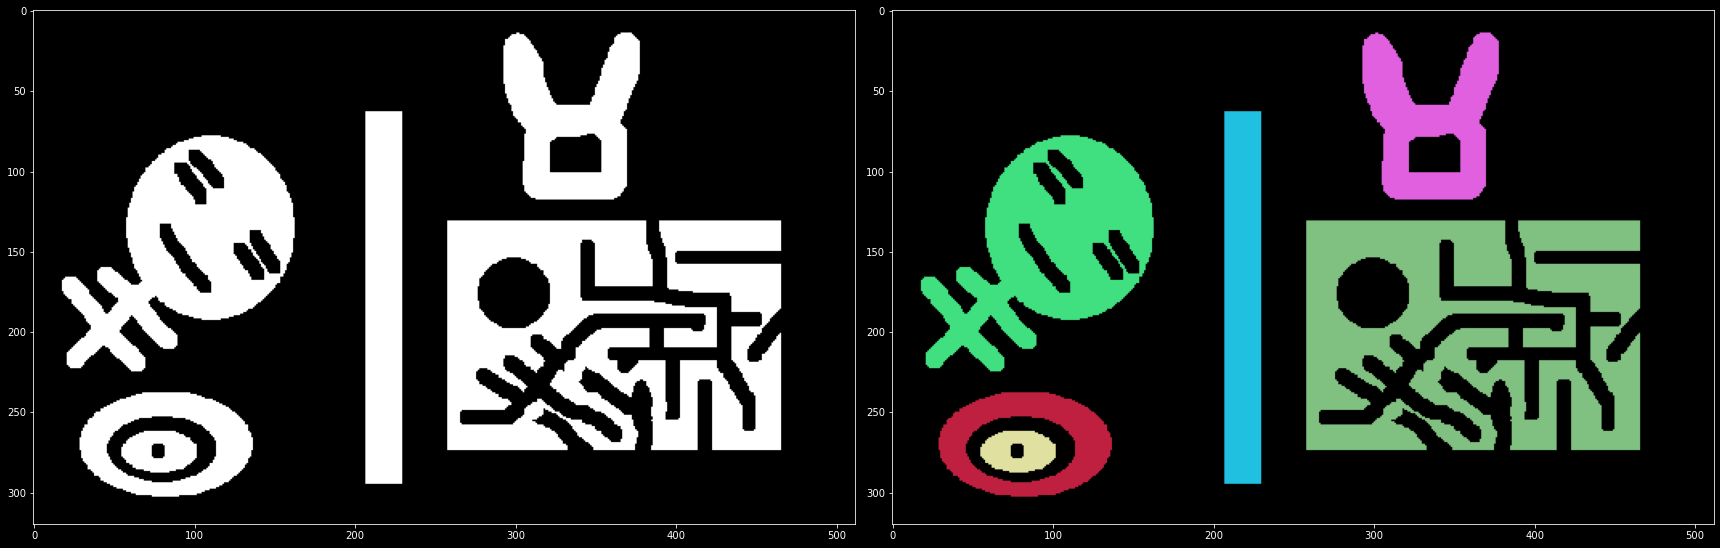

In [7]:
show_contour_tracing('./data/dummy.png')

100%|██████████| 512/512 [00:02<00:00, 230.07it/s]


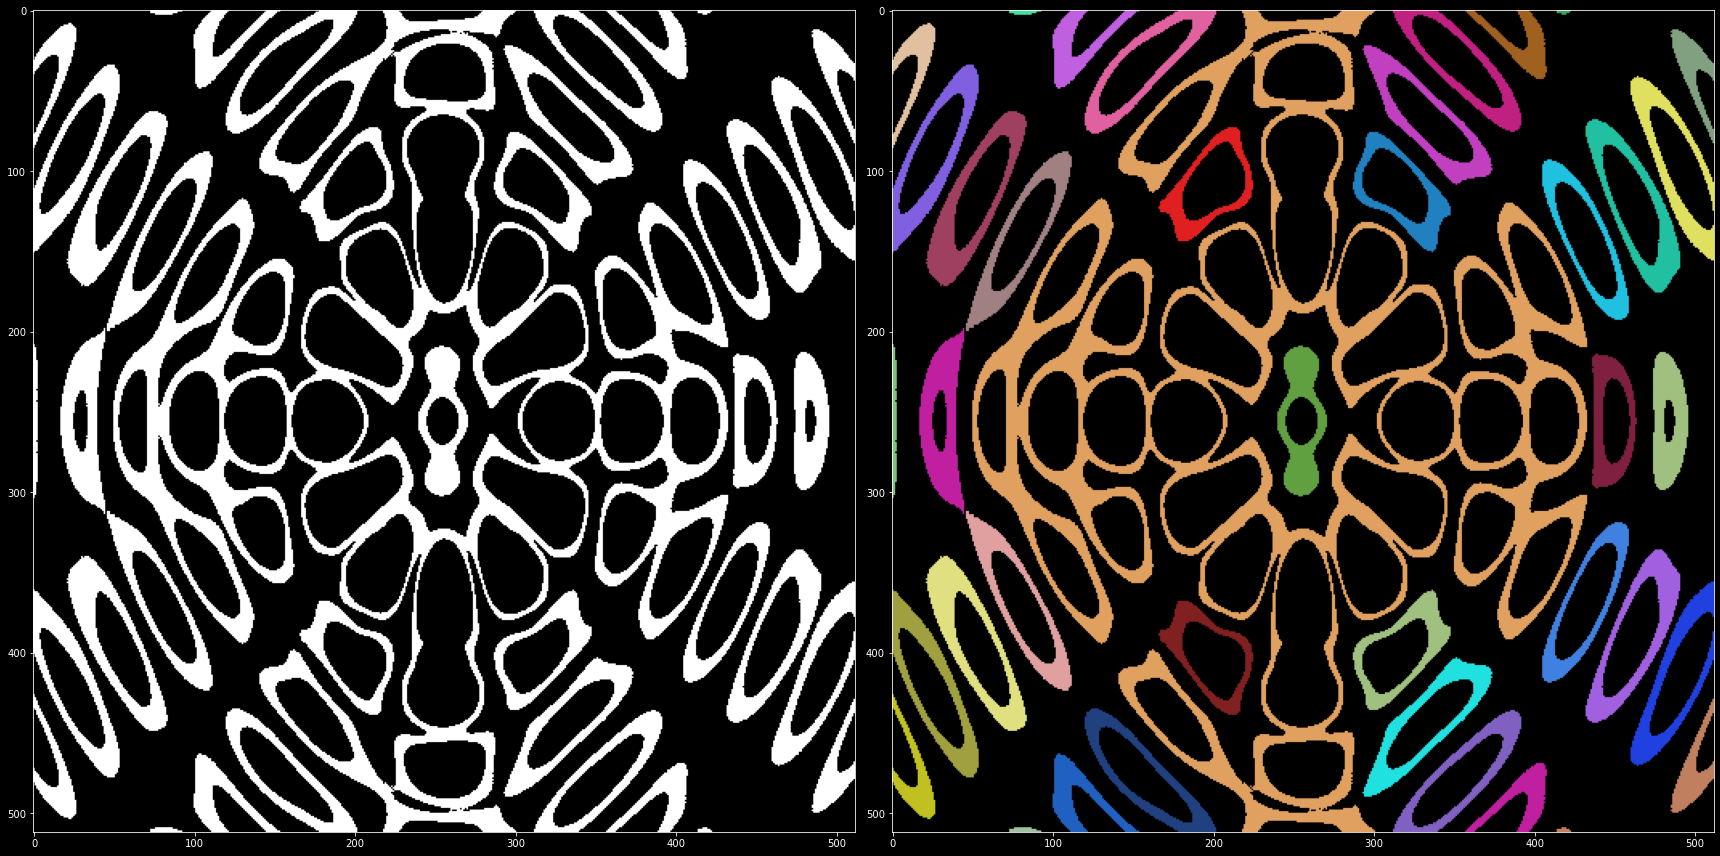

In [8]:
show_contour_tracing('./data/diffract.png')

100%|██████████| 600/600 [00:06<00:00, 89.51it/s] 


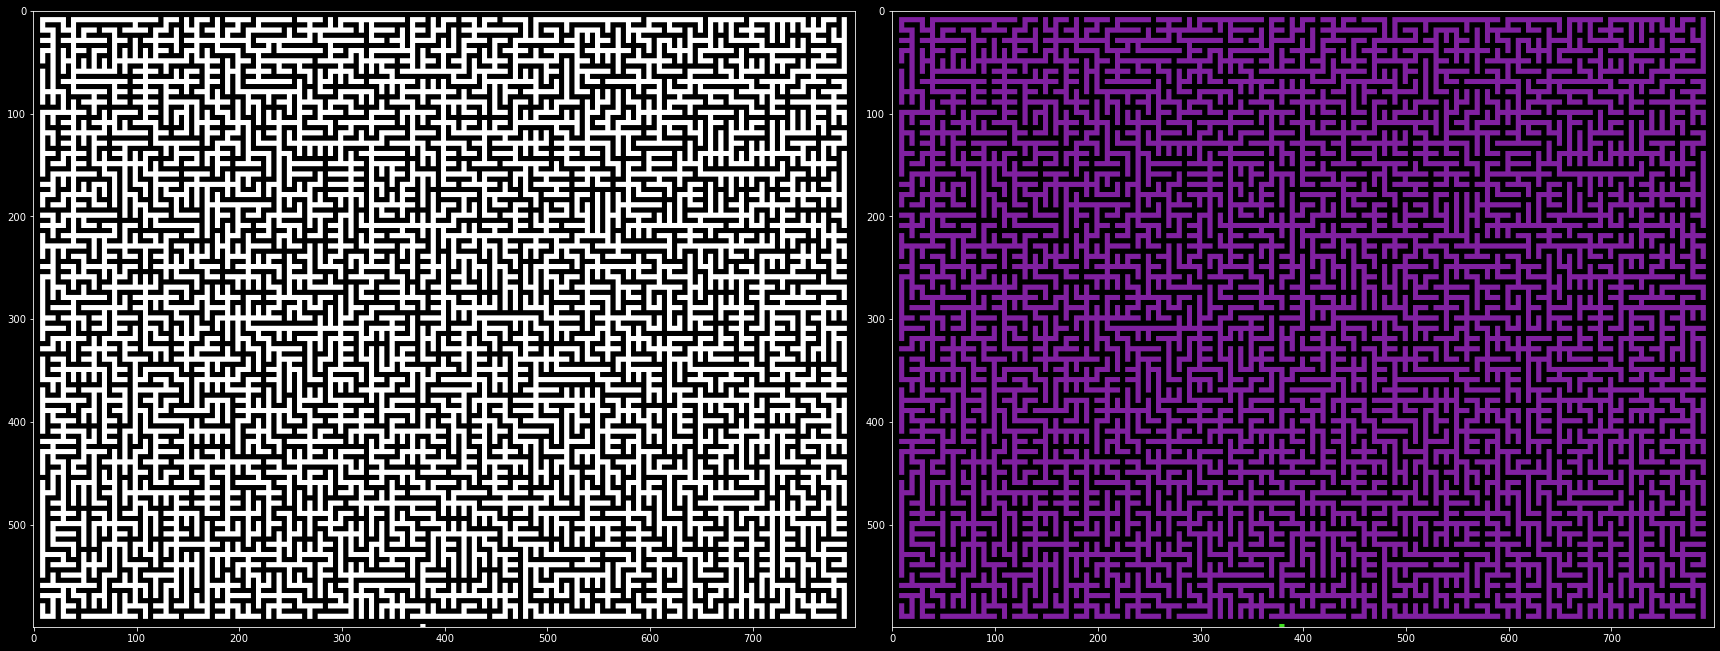

In [9]:
show_contour_tracing('./data/labyrinth.png')

100%|██████████| 32/32 [00:00<00:00, 1636.40it/s]


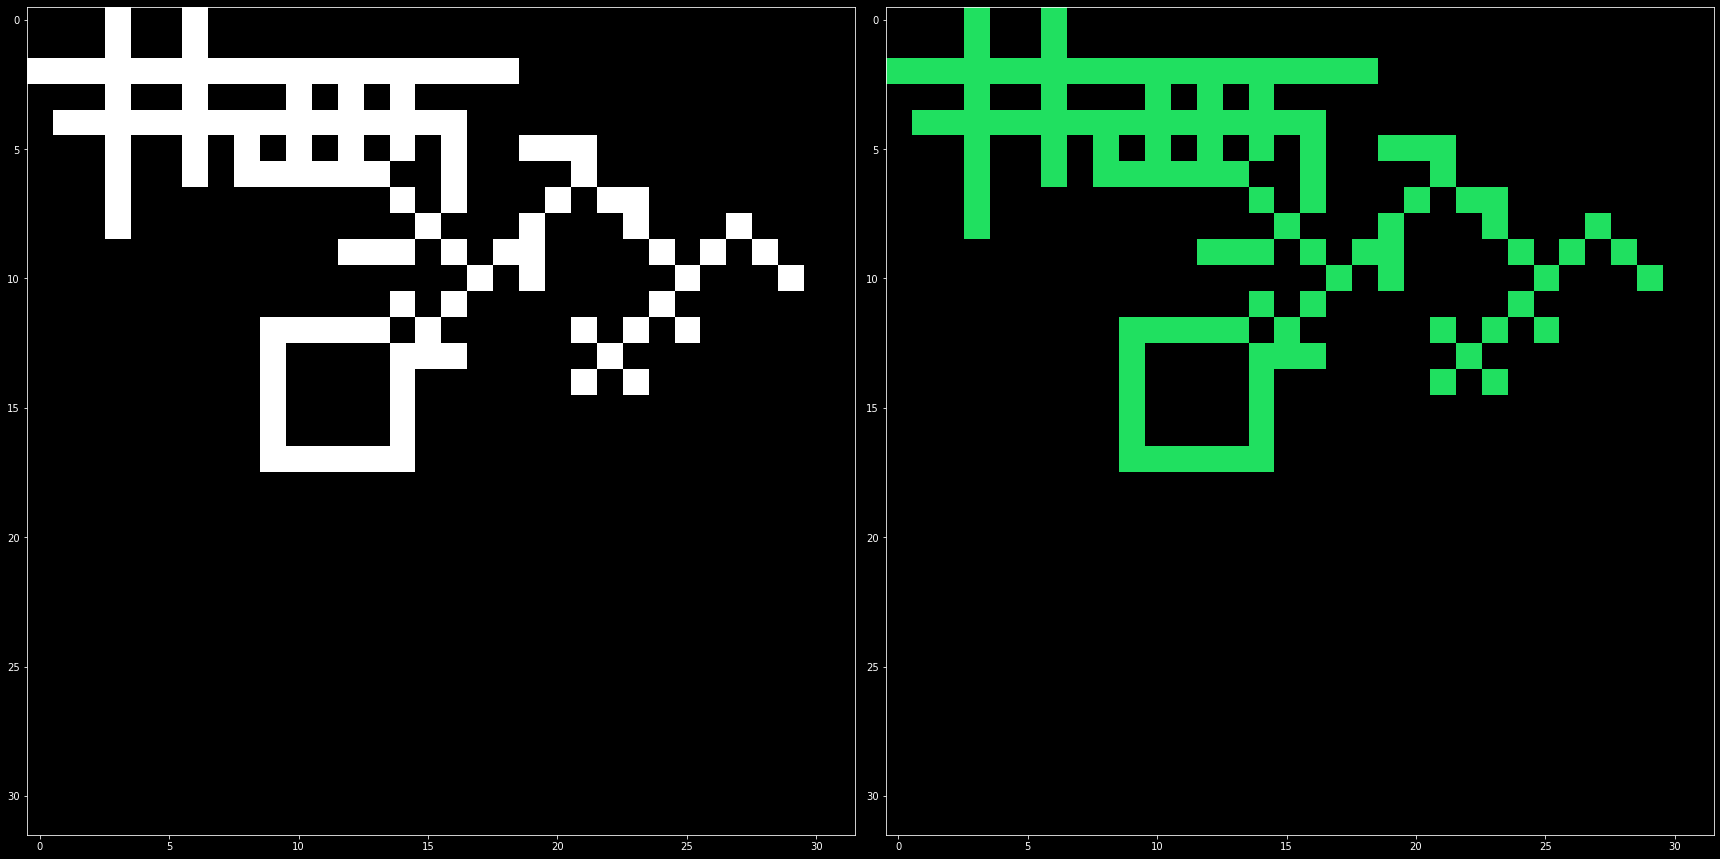

In [10]:
show_contour_tracing('./data/lines.png')

100%|██████████| 8/8 [00:00<00:00, 5528.82it/s]


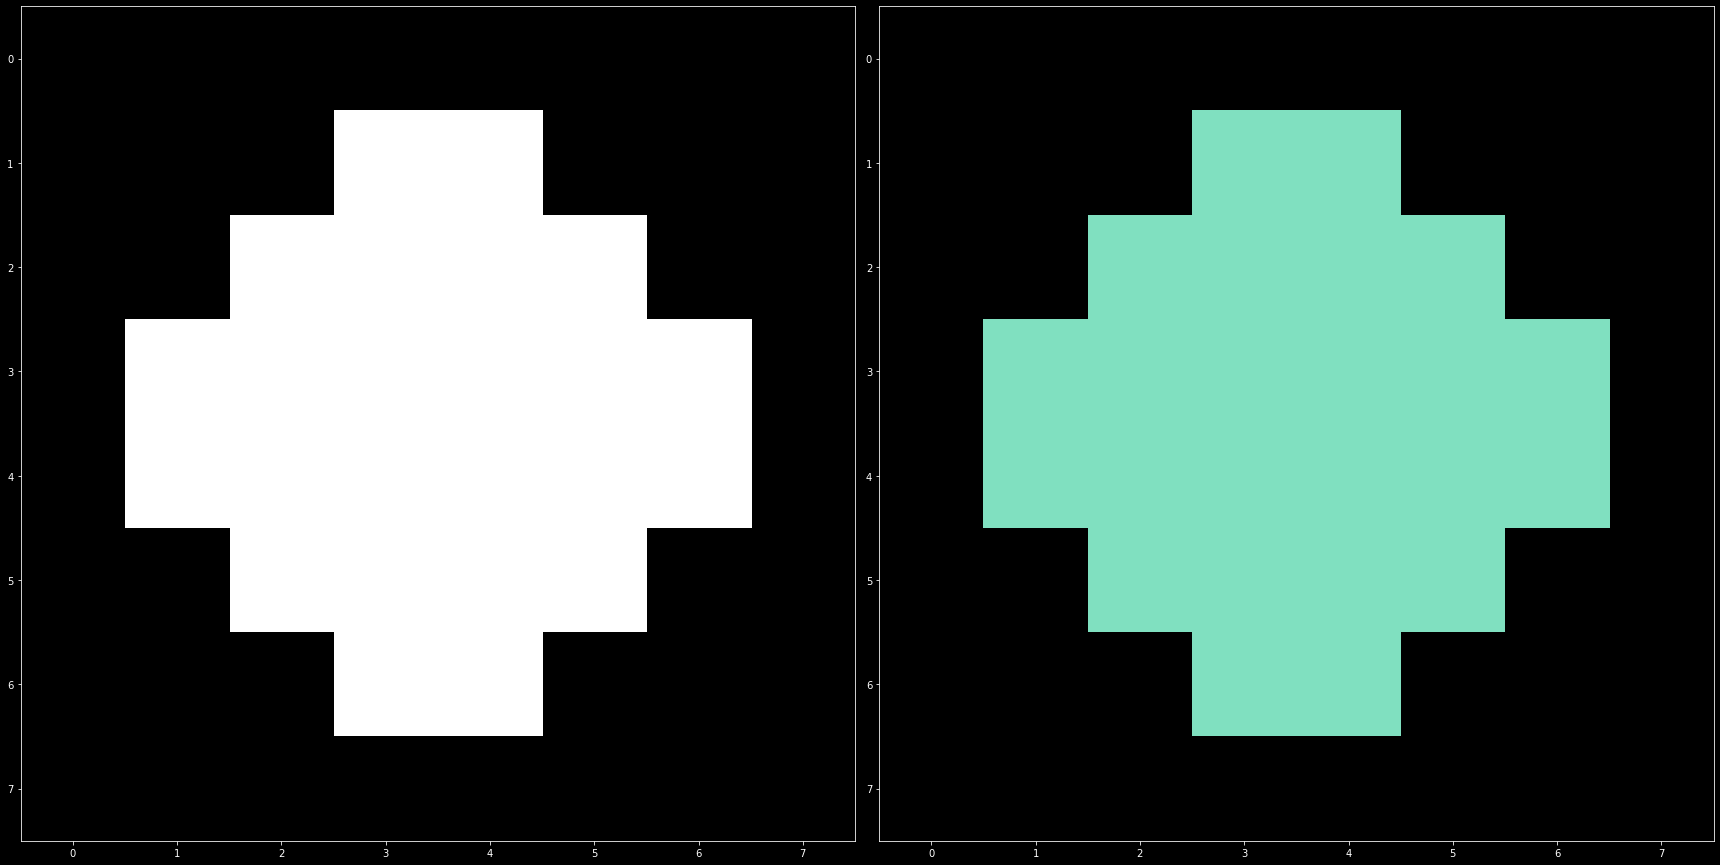

In [11]:
show_contour_tracing('./data/simple.png')